# GRPO

The core innovation of GRPO is its approach to evaluating and learning from multiple generated responses simultaneously. Instead of relying on a seperate reward model. it compares outputs within the same group to determine which ones should be reinforced.

TLDR: GRPO > PPO & DPO for reasoning tasks.

1. No Need for a Reward Model
GRPO eliminates the need for a separate reward model like PPO or DPO require. Instead, it compares responses within the same group and learns from relative differences — this simplifies training, reduces dependencies, and avoids the brittleness of reward model design.

2. Group-Based Learning = More Stable & Informative
Unlike DPO (which only compares pairs) or PPO (which updates based on individual samples), GRPO evaluates multiple completions per prompt (typically 4–16). This gives a richer signal, reduces variance, and allows the model to learn from relative quality within a group — similar to how humans review multiple drafts.

3. Better Alignment Without Supervised Fine-Tuning
GRPO enabled the creation of DeepSeek-R1-Zero — a model trained purely with RL, yet achieving state-of-the-art reasoning. This challenges the conventional wisdom that supervised fine-tuning is necessary for high-quality alignment, and proves RL alone can unlock structured reasoning behavior.

4. Built-In Safety via KL Penalty
Like PPO, GRPO includes a KL divergence penalty to prevent the model from drifting too far from its previous behavior. This acts as a guardrail, maintaining stability without freezing learning. It allows controlled exploration rather than wild swings in behavior.

5. Adaptable to Any Reward Function
GRPO isn’t tied to any specific reward format — it can learn from correctness (math), formatting (code), conciseness (length), or even structured scores from another LLM. This flexibility makes GRPO easier to apply to real-world tasks, especially where human preferences are hard to model explicitly.



## Step 1: Group Sampling
The first step is to generate multiple possible answers for each question. This creates a diverse set of outputs that can be compared against each other.

For each question, q, the model will generate, G, outputs (group size) from the trained policy: {o1, o2, ..., oG}, G = 8 each each oi represents one completion from the model

### Example:

Question q: Calculate 2 + 2 x 6
outputs (G=8):{o1: 14 (correct), o2: 16 {wrong}, o3: 10 (wrong), ..., o8: 14 (correct)}

## Step 2: Advantage Calculation

Once we have multiple responses, we need a way to determine which ones are better than others. This is where the advantage calculation comes in.

$$
A_i = \frac{r_i - \text{mean}(\{r_1, r_2, \dots, r_G\})}{\text{std}(\{r_1, r_2, \dots, r_G\})}
$$

This is useful because, during training, we want the model to increase the probability of taking actions that lead to higher rewards. However, not all actions are equally informative. By using the advantage, we can focus updates only on those actions that led to better-than-expected outcomes. If the advantage is positive, it means the action was better than the average, and we want to reinforce it. If it’s negative, the action was worse than average, and we want to reduce its likelihood.

Using advantages also helps reduce variance in the training signal. In standard REINFORCE-style algorithms, we often rely on the total reward of a trajectory, which can be noisy and hard to attribute to individual decisions. The advantage function mitigates this by subtracting a baseline — the value function — which helps stabilize training and makes learning more efficient.


### Example:

imagine we have 8 responses, 4 of which are correct and the remaining 4 are incorrect. We define the reward function such that:

A correct response receives a reward of 1

An incorrect response receives a reward of 0

So, the reward vector is:

r=[1,1,1,1,0,0,0,0]

We can compute the average reward (mean), standard deviation, and the normalized advantage for both correct and incorrect responses as follows:
| Statistic | Value |
|-----------|-------|
| Group Average | $\text{mean}(r_i) = 0.5$ |
| Standard Deviation | $\text{std}(r_i) = 0.53$ |
| Advantage Value (Correct response) | $A_i = \frac{1 - 0.5}{0.53} = 0.94$ |
| Advantage Value (Wrong response) | $A_i = \frac{0 - 0.5}{0.53} = -0.94$ |
In this case, we use a normalized advantage by subtracting the mean reward and dividing by the standard deviation:

### Interpretation

The standardization from the advantage calculation allows the model to asses each response's relative performance, guiding the optimization process to favorable responses that are better than average (high reward) and discourage those that are worse. For instance if A_i > 0 then the o_i is a better response than the average level within its group. And if A_i < 0 then the o_i is a worse response than the average level within its group.

Advantage vector is A = [0.94, 0.94, 0.94, 0.94, -0.94, -0.94, -0.94, -0.94]

For the example above, if A_i = 0.94, then during optimization steps its generation pobability will be increaseed, if A_i = -0.94, then during optimization steps its generation probability will be decreased.

## Step 3: Policy Update

The final step is to use these advantage values to update our model so that it becomes more likely to generate good responses in the future.

The target function for policy update is:

$$
J_{\text{GRPO}}(\theta) = \frac{1}{G} \sum_{i=1}^{G} \min\left(
\frac{\pi_\theta(o_i \mid q)}{\pi_{\theta_{\text{old}}}(o_i \mid q)} A_i,\ 
\text{clip}\left( 
\frac{\pi_\theta(o_i \mid q)}{\pi_{\theta_{\text{old}}}(o_i \mid q)},\ 1 - \epsilon,\ 1 + \epsilon 
\right) A_i
\right) - \beta \, D_{\text{KL}}\left( \pi_\theta \,\|\, \pi_{\text{ref}} \right)
$$

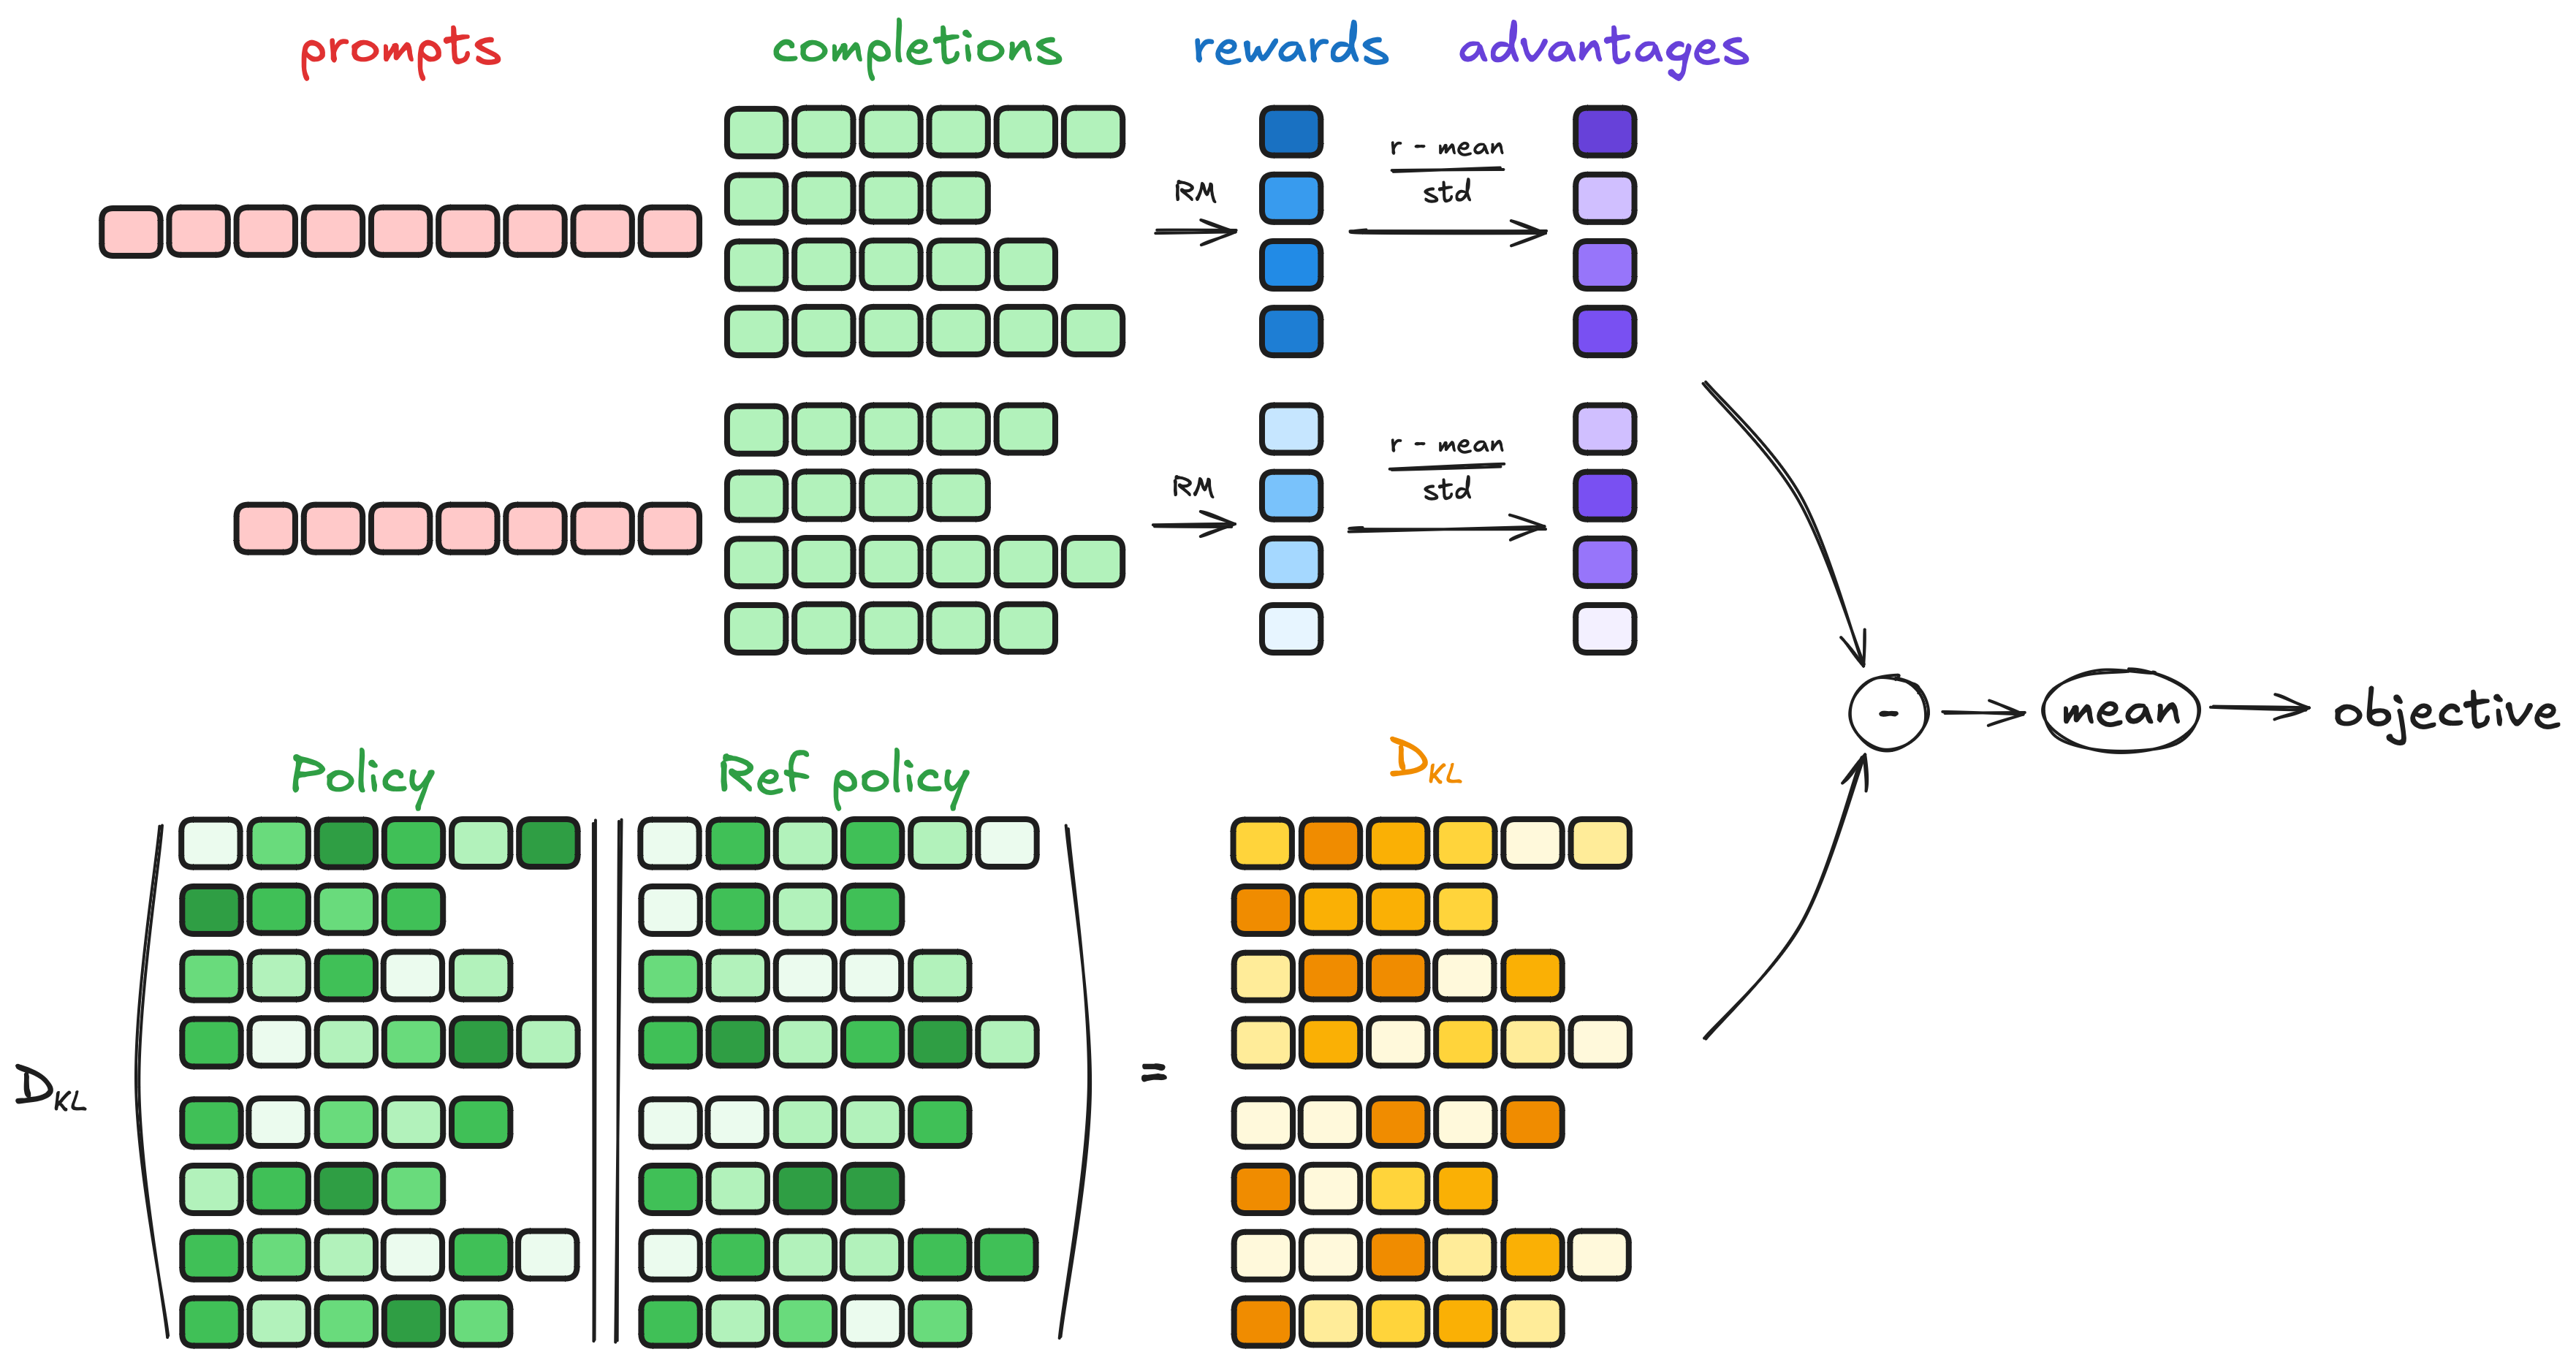
Source: https://huggingface.co/learn/cookbook/en/fine_tuning_llm_grpo_trl

This formula might look intimidating at first, but it’s built from several components that each serve an important purpose. Let’s break them down one by one.

### Key Compoenents of the Target Function:

# Key Components of the Target Function

The GRPO update function combines several techniques to ensure stable and effective learning. Let's examine each component:

## 1. Probability Ratio

The probability ratio is defined as: 
$$\frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}$$

Intuitively, the formula compares how much the new model's response probability differs from the old model's response probability while incorporating a preference for responses that improve the expected outcome.

### Interpretation
- If $\text{ratio} > 1$, the new model assigns a higher probability to response $o_i$ than the old model.
- If $\text{ratio} < 1$, the new model assigns a lower probability to $o_i$

This ratio allows us to control how much the model changes at each step, which leads us to the next component.

## 2. Clip Function

The clipping function is defined as: 
$$\text{clip}\left(\frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}, 1-\epsilon, 1+\epsilon\right)$$

Limit the ratio discussed above to be within $[1-\epsilon, 1+\epsilon]$ to avoid/control drastic changes or crazy updates and stepping too far off from the old policy. In other words, it limit how much the probability ratio can increase to help maintaining stability by avoiding updates that push the new model too far from the old one.

### Example ($\epsilon = 0.2$)
Let's look at two different scenarios to better understand this clipping function:

**Case 1**: If the new policy has a probability of 0.9 for a specific response and the old policy has a probabiliy of 0.5, it means this response is getting reinforeced by the new policy to have higher probability, but within a controlled limit which is the clipping to tight up its hands to not get drastic -
$$\text{Ratio}: \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)} = \frac{0.9}{0.5} = 1.8 \rightarrow \text{Clip } 1.2 \text{ (upper bound limit 1.2)}$$

**Case 2**: If the new policy is not in favour of a response (lower probability e.g. 0.2), meaning if the response is not beneficial the increase might be incorrect, and the model would be penalized. -
$$\text{Ratio}: \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)} = \frac{0.2}{0.5} = 0.4 \rightarrow \text{Clip } 0.8 \text{ (lower bound limit 0.8)}$$

### Interpretation
- The formula encourages the new model to favour responses that the old model underweighted if they improve the outcome.
- If the old model already favoured a response with a high probability, the new model can still reinforce it but only within a controlled limit $[1-\epsilon, 1+\epsilon]$, (e.g., $\epsilon=0.2$, so $[0.8-1.2]$).
- If the old model overestimated a response that performs poorly, the new model is discouraged from maintaining that high probability.

Therefore, intuitively, by incorporating the probability ratio, the objective function ensures that updates to the policy are proportional to the advantage $A_i$ while being moderated to prevent drastic changes.

While the clipping function helps prevent drastic changes, we need one more safeguard to ensure our model doesn't deviate too far from its original behavior.

## 3. KL Divergence

The KL divergence term is: 
$$\beta D_{KL}(\pi_\theta \parallel \pi_{ref})$$

In the KL divergence term, the $\pi_{ref}$ is basically the pre-update model's output, per_token_logps and $\pi_\theta$ is the new model's output, new_per_token_logps. Theoretically, KL divergence is minimized to prevent the model from deviating too far from its original behavior during optimization. This helps strike a balance between improving performance based on the reward signal and maintaining coherence. In this context, minimizing KL divergence reduces the risk of the model generating nonsensical text or, in the case of mathematical reasoning, producing extremely incorrect answers.

### Interpretation
- A KL divergence penalty keeps the model's outputs close to its original distribution, preventing extreme shifts.
- Instead of drifting towards completely irrational outputs, the model would refine its understanding while still allowing some exploration

### Math Definition
For those interested in the mathematical details, let's look at the formal definition:

Recall that KL distance is defined as follows:
$$D_{KL}(P \parallel Q) = \sum_{x \in X} P(x) \log \frac{P(x)}{Q(x)}$$

In RLHF, the two distributions of interest are often the distribution of the new model version, P(x), and a distribution of the reference policy, Q(x).

### The Role of $\beta$ Parameter
The coefficient $\beta$ controls how strongly we enforce the KL divergence constraint:

**Higher $\beta$ (Stronger KL Penalty)**
- More constraint on policy updates. The model remains close to its reference distribution.
- Can slow down adaptation: The model may struggle to explore better responses.

**Lower $\beta$ (Weaker KL Penalty)**
- More freedom to update policy: The model can deviate more from the reference.
- Faster adaptation but risk of instability: The model might learn reward-hacking behaviors.
- Over-optimization risk: If the reward model is flawed, the policy might generate nonsensical outputs.

Original DeepSeekMath paper set this $\beta=0.04$

Now that we understand the components of GRPO, let's see how they work together in a complete example.

# Worked Example with GRPO

To solidify our understanding of GRPO, let's walk through a complete example from start to finish.

## Example Problem
Q: Calculate $2+2×6$

### Step 1: Group Sampling
First, we generate multiple responses from our model.

Generate $(G=8)$ responses, $4$ of which are correct answer ($14$, reward$= 1$) and $4$ incorrect (reward$= 0$), Therefore:
$$o_1: 14 \text{ (correct)}, o_2: 10 \text{ (wrong)}, o_3: 16 \text{ (wrong)}, ... o_G: 14 \text{ (correct)}$$

### Step 2: Advantage Calculation

r=[1,1,1,1,0,0,0,0]

Next, we calculate the advantage values to determine which responses are better than average:

| Statistic | Value |
|-----------|-------|
| Group Average | $\text{mean}(r_i) = 0.5$ |
| Standard Deviation | $\text{std}(r_i) = 0.53$ |
| Advantage Value (Correct response) | $A_i = \frac{1 - 0.5}{0.53} = 0.94$ |
| Advantage Value (Wrong response) | $A_i = \frac{0 - 0.5}{0.53} = -0.94$ |

A = [0.94, 0.94, 0.94, 0.94, -0.94, -0.94, -0.94, -0.94]

### Step 3: Policy Update
Finally, we update our model to reinforce the correct responses:

Assuming the probability of old policy ($\pi_{\theta_{old}}$) for a correct output $o_1$ is $0.5$ and the new policy increases it to $0.7$ then:
$$\text{Ratio}: \frac{0.7}{0.5} = 1.4 \rightarrow \text{after Clip } 1.2 \text{ } (\epsilon=0.2)$$

Then when the target function is re-weighted, the model tends to reinforce the generation of correct output, and the KL Divergence limits the deviation from the reference policy.

With the theoretical understanding in place, let's see how GRPO can be implemented in code.

## Reward Implementation

When designing reward functions in GRPO, the most important principle is clarity and consistency. Since GRPO compares completions within a group, your reward function doesn’t have to be globally perfect — it just needs to rank completions accurately relative to each other. This makes it easier to define rewards even for fuzzy or subjective criteria.

Also, consider the parseability and robustness of your reward logic. If your reward function depends on extracting answers or tags, make sure your code can handle malformed completions gracefully (e.g., give low reward instead of crashing). Finally, experiment with group size — too small (e.g. 2) reduces diversity, while too large (e.g. 16+) can increase cost and memory usage. A sweet spot is usually 4 to 8 completions per prompt.

1. Length-Based Rewards
Reward completions based on their length — longer, more elaborate completions often correlate with deeper reasoning or better formatting. You can use ideal-length targets (e.g., penalizing answers that are too short or too long).

2. Correctness-Based (Rule-Based) Rewards
For verifiable tasks (e.g., math, coding), use exact or parsed answer matching to reward only correct solutions. This is objective and works well when there’s a single right answer.

3. Format-Based Rewards
Reward completions that follow specific structural formats (e.g., <think>...</think><answer>...</answer>). This is helpful for tasks that require a reasoning-first or step-by-step format.

4. Pattern Matching Rewards
Similar to formatting, but focused on detecting whether specific keywords, templates, or token sequences appear (e.g., correct use of XML, equations, or citations).

5. Composite or Heuristic Rewards
Combine multiple reward signals — such as correctness + formatting + brevity — to align model outputs with nuanced human preferences. This gives the model a richer, more holistic learning signal.

References:

[GRPO Cookbook](https://huggingface.co/learn/cookbook/en/fine_tuning_llm_grpo_trl)

[Bite: How Deepseek R1 was trained](https://www.philschmid.de/deepseek-r1)

[Advanced Understanding of Group Relative Policy Optimization (GRPO) in DeepSeekMath](https://huggingface.co/learn/nlp-course/en/chapter12/3a)

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, PreTrainedModel, PreTrainedTokenizerBase
from typing import Tuple

: 

In [2]:
def expand_inputs(
    input_ids: torch.Tensor, attention_mask: torch.Tensor, total_samples: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Expand input tensors to replicate the prompt for group sampling.

    Args:
        input_ids: Tensor of shape (batch_size, seq_len).
        attention_mask: Tensor of same shape.
        total_samples: Total number of responses to generate (batch_size * group_size).

    Returns:
        Tuple of expanded input_ids and attention_mask, both with shape (total_samples, seq_len).
    """
    return input_ids.repeat(total_samples, 1), attention_mask.repeat(total_samples, 1)

In [3]:
@torch.no_grad()
def generate_samples(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    max_new_tokens: int = 1,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate completions using sampling for diversity.

    Args:
        model: The causal language model to generate from.
        tokenizer: HuggingFace tokenizer.
        input_ids: Input prompt tensor.
        attention_mask: Matching attention mask.
        max_new_tokens: How many tokens to generate.

    Returns:
        Tuple of:
            - generated_token_ids: (batch_size,) tensor of new token ids
            - sequences: Full sequences (prompt + generation)
            - scores: Logits at generated step (used for logprobs)
    """
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=10,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id,
        output_scores=True,
        return_dict_in_generate=True,
    )
    prompt_len = input_ids.shape[1]
    generated_token_ids = outputs.sequences[:, prompt_len]
    return generated_token_ids, outputs.sequences, outputs.scores

In [4]:
def compute_rewards(
    generated_token_ids: torch.Tensor, tokenizer: PreTrainedTokenizerBase, target_text: str
) -> torch.Tensor:
    """
    Compute rewards via exact match with target text.

    Args:
        generated_token_ids: Tensor of shape (N,) of token ids.
        tokenizer: HuggingFace tokenizer.
        target_text: Ground truth answer string.

    Returns:
        Tensor of float rewards (1.0 if match, else 0.0).
    """
    generated_texts = tokenizer.batch_decode(generated_token_ids, skip_special_tokens=True)
    rewards = [1.0 if text.strip() == target_text else 0.0 for text in generated_texts]
    return torch.tensor(rewards, dtype=torch.float32, device=generated_token_ids.device)

In [5]:
def compute_advantages(rewards: torch.Tensor, batch_size: int, group_size: int) -> torch.Tensor:
    """
    Compute normalized group-wise advantages from rewards.

    Args:
        rewards: Tensor of shape (batch_size * group_size,).
        batch_size: Number of query prompts.
        group_size: Number of samples per prompt.

    Returns:
        Flattened advantage tensor of shape (batch_size * group_size,).
    """
    grouped_rewards = rewards.view(batch_size, group_size)
    mean = grouped_rewards.mean(dim=1, keepdim=True)
    std = grouped_rewards.std(dim=1, unbiased=False, keepdim=True)
    return ((grouped_rewards - mean) / (std + 1e-8)).view(-1)

In [6]:
def compute_log_probs(
    model: PreTrainedModel,
    sequences: torch.Tensor,
    generated_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    require_grad: bool = False,
    device: str = "cuda",
) -> torch.Tensor:
    """
    Compute log probabilities for generated tokens.

    Args:
        model: HuggingFace causal LM.
        sequences: Full sequences (prompt + generated token).
        generated_ids: Token ids that were generated (to index logprobs).
        attention_mask: Mask for the full sequence (including generated).
        require_grad: Whether to enable gradients (for backprop).
        device: Device to run on.

    Returns:
        Tensor of shape (batch_size * group_size,) with log probabilities.
    """
    model.train() if require_grad else model.eval()

    # Extend attention mask to include the generated token
    full_mask = torch.cat(
        [
            attention_mask.repeat(sequences.size(0), 1),
            torch.ones((sequences.size(0), 1), dtype=torch.long, device=device),
        ],
        dim=1,
    )

    with torch.set_grad_enabled(require_grad):
        logits = model(sequences, attention_mask=full_mask).logits[:, -1, :]  # Last token logits
        log_probs = F.log_softmax(logits, dim=-1)
        return torch.gather(log_probs, dim=1, index=generated_ids.unsqueeze(1)).squeeze(-1)

In [ ]:
def compute_grpo_loss(
    old_logps: torch.Tensor,
    new_logps: torch.Tensor,
    advantages: torch.Tensor,
    epsilon: float,
    beta: float,
) -> torch.Tensor:
    """
    Compute GRPO loss as defined by:

        J_GRPO(θ) = (1/G) * Σ_i min(
            r_i * A_i,
            clip(r_i, 1 - ε, 1 + ε) * A_i
        ) - β * D_KL(π_θ || π_ref)

    where:
        - r_i = π_θ(o_i | q) / π_θ_old(o_i | q) = exp(log_new - log_old)
        - A_i is the advantage
        - KL is approximated by (log_new - log_old).mean()

    Args:
        old_logps: Log probs from old (reference) policy. Shape: (G,)
        new_logps: Log probs from new (current) policy. Shape: (G,)
        advantages: Advantage values per sample. Shape: (G,)
        epsilon: Clipping range for PPO surrogate objective.
        beta: KL penalty coefficient.

    Returns:
        Scalar GRPO loss tensor.
    """
    log_ratio = new_logps - old_logps  # log(π_new / π_old)
    ratio = torch.exp(log_ratio)  # π_new / π_old

    # Clipped policy gradient term: min(r * A, clip(r, 1 - ε, 1 + ε) * A)
    unclipped = ratio * advantages
    clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
    surrogate = torch.min(unclipped, clipped)
    pg_loss = -surrogate.mean()  # Negative sign to minimize loss

    # KL divergence penalty: approximate as mean(log_new - log_old)
    kl_divergence = log_ratio.mean()
    kl_penalty = beta * kl_divergence

    return pg_loss + kl_penalty

In [8]:
# Hyperparameters
model_name = "Qwen/Qwen2-Math-1.5B"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prompt = "Solve y = 2x + 1 for x = 2, y = "  # Correct answer: 5
target_answer = "5"
batch_size = 2
group_size = 4
epsilon = 0.2
beta = 0.04

In [9]:
# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval().to(device)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [ ]:
# Tokenize input to get ids and attention mask
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Get samples
total_samples = batch_size * group_size

# Expand input for all generations (Make copies of the sample to show scaling)
expanded_ids, expanded_mask = expand_inputs(input_ids, attention_mask, total_samples)

# Step 1: Sample outputs
gen_ids, full_sequences, _ = generate_samples(model, tokenizer, expanded_ids, expanded_mask)
print(f"\nGenerated IDs: {gen_ids}")

# Step 2: Compute rewards
rewards = compute_rewards(gen_ids, tokenizer, target_answer)
print(f"\nRewards: {rewards}")

# Step 3: Compute advantages
advantages = compute_advantages(rewards, batch_size, group_size)
print(f"\nAdvantages: {advantages}")

# Step 4: Log probs (old and new)
logps_old = compute_log_probs(model, full_sequences, gen_ids, attention_mask, require_grad=False)
logps_new = compute_log_probs(model, full_sequences, gen_ids, attention_mask, require_grad=True)

# Step 5: Compute loss
loss = compute_grpo_loss(logps_old, logps_new, advantages, epsilon, beta)

# Final output
print(f"\nTotal GRPO Loss: {loss.item():.4f}")


Total GRPO Loss: -0.0000
